# **<center>Notebook: Advanced (Causal) Method for Exploration</center>**


**References:**
1. Hu, X., Zhang, R., Tang, K., Guo, J., Yi, Q., Chen, R., ... & Chen, Y. (2022). Causality-driven hierarchical structure discovery for reinforcement learning. Advances in Neural Information Processing Systems, 35, 20064-20076.

In this notebook we present the implementation of our own method to integrate causality into reinforcement learnning as a method to improve exploration. The method is called **variable-agnostic causal exploration** (VACERL).

## **1. Setting up the libraries** 

In [9]:
# Run these commands from the terminal to install related libraries and set up the working environment
# pip install gymnasium # Install the gymnasium library with RL environments
# pip install stable-baselines3 # Install the Stable Baselines 3 library contains RL Algorithm

In [2]:
import os, random, time
from collections import deque
from dataclasses import dataclass

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium.core import Wrapper
from stable_baselines3 import PPO
from callbacks.Eval_Callback import Eval_Callback

random.seed(1)                                                 
np.random.seed(1)
torch.manual_seed(1)
torch.backends.cudnn.deterministic = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## **2. Introducing the Frozenlake Environment**

- 👋 In this notebook, we will use the FrozenLake environment, specifically the FrozenLake-v1. FrozenLake environment is part of the Toy Text environments available on gymnasium (https://gymnasium.farama.org/environments/toy_text/frozen_lake/).    
- The environment involves crossing a frozen lake from start to goal without falling into any holes by walking over the frozen lake. The game starts with the agent at location [0,0] of the frozen lake grid world with the goal located at far extent of the world.
- There is an option called "slippery" wherein the agent may not always move in the intended direction due to the slippery nature of the frozen lake. Here, we are using the normal version where the movement of the agent is not affected by slippery. ❄️🚶‍♂️🎯

<p align="center">
  <img src="https://gymnasium.farama.org/_images/frozen_lake.gif" width="300" height="300">
</p>


- The action shape is (1,) of number in the range {0, 3} indicating which direction the agent will move. 

<span style=" font-weight:bold;">Action Space</span>
| Num   | Name | 
|--------|-----|
| 0  | left  | 
| 1    | down  | 
| 2| right | 
| 3  | up  |
- The observation is a value representing the player’s current position as current_row * nrows + current_col. Eg: the goal position in the above map is calculated as: $ 3 \times 4+3=15$. This will also be the number of position in the map.



## **3. Simple PPO**

- In this section, we will test a simple PPO algorithm on the above FrozenLake environment. 🕹️
- Here, we use the implementation of PPO from Stable Baselines 3. 📊
- The result of this algorithm will be presented at the end of the notebook. 📝

In [ ]:
simple_ppo_reward = {}

for run in range(5):
    env = gym.make('FrozenLake-v1', max_episode_steps=100, desc=None, map_name="4x4", is_slippery=False)

    # env = gym.wrappers.TimeLimit(env, 100)

    eval_callback = Eval_Callback(eval_env=env, eval_freq=500, n_eval_episodes=20)

    policy = PPO("MlpPolicy", env=env, verbose=1, ent_coef=0.005)

    policy.learn(total_timesteps=10000, callback=eval_callback)

    simple_ppo_reward[f"run_{run}"] = eval_callback.record_reward

## **4. Causal Intrinsic Reward**

- In this section, we present the implementation of an causal intrinsic reward method, for improving explorattion, that we recently worked on. We call this the variable-agnostic causal exploration (VACERL) method. 🚀
- The method has demonstrated significant successes when compared to baselines, prompting us to consider publishing a research paper detailing this method. 📝
- We implement it as a wrapper to the FrozenLake environment -> modifying the .step() function, so as to include the bonus reward. 🔧
- The result of this algorithm will be presented at the end of the notebook. 📊

### **4.1 Key Points**

- The main motivation behind this method is to introduce a causal approach to RL that does not require variable informations (E.g.: the number of variables, variable types) and does not require factorizable environments (E.g.: 2 arms robot where two arms work together). 
- Given that we do not have variable informations, we use observation-action (o,a) pairs in memory of the agent as causal nodes.  
- The method composes of 3 module. A transformer neural network to detect crucial (observation,action) nodes. A SCM learning phase that learn the SCM between these crucial nodes. And, the integration of this causal information into agent training as an exploration enhancement.
- The integration is done as an intrinsic reward given to (o,a) pairs in the causal tree by the formula: $r_{causal}(o,a) = r_g - (d-1) \times r_0$ where $r_g$ is the reward for reaching the goal state, $d$ is the depth in the hierachy causal tree, and $r_0$ is a hyperparmeter.

<div style="text-align:center">
    <img src="./image/VACERL.png" alt="AutoEncoder forr Count Based Exploration" width="600" height="250">
</div>



### **4.2 Model**

#### **4.2.1 Transformer Module**

- To detect the crucial steps, we train a Transformer $TF$ with loss: $$(o_T,a_T)=TF(o_t,a_t)_{t=1}^{T-1}$$ 
- We then rank the steps based on the attention score and get the top M hiighest ranking steps to add to a crucial step set ($S_{COAS}$)

In [13]:
def update_att_dict(dict_attention_state_action, input_sequence, attention_weights):
    attention_weights = tuple(attention_weights.detach().numpy())
    for i in range(len(input_sequence)): 
        key = tuple(input_sequence[i].detach().numpy())
        if key in dict_attention_state_action.keys():
            [current_value, current_count, _, _] = dict_attention_state_action[key]
            new_value = float(attention_weights[i])
            current_count += 1
            dict_attention_state_action[key] = [max(current_value, new_value), current_count, int(key[0]), int(key[1])] 
        else:
            dict_attention_state_action[key] = [float(attention_weights[i]), 1, int(key[0]), int(key[1])]
    return dict_attention_state_action

def patch_attention(m):
    forward_orig = m.forward
    def wrap(*args, **kwargs):
        kwargs["need_weights"] = True
        kwargs["average_attn_weights"] = False
        return forward_orig(*args, **kwargs)
    m.forward = wrap

class SaveOutput:
    def __init__(self):
        self.outputs = []

    def __call__(self, module, module_in, module_out):
        self.outputs.append(module_out[1])

    def clear(self):
        self.outputs = []


class TransformerModel(nn.Module):
    def __init__(self, input_dim, nhead=2, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=256, dropout=0.1):
        super(TransformerModel, self).__init__()

        self.transformer = nn.Transformer(
            d_model=input_dim,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout
        )

    def forward(self, src, tgt):
        tgt = tgt.unsqueeze(0)
        output = self.transformer(src, tgt)
        return output

#### **4.2.2 Structure Causal Learning Module**

- For training the Structural Causal Model (SCM), we use a two-phase optimization process similar to that described in the paper "Causality-driven hierarchical structure discovery for reinforcement learning", focusing on optimizing parameters $\theta$ and $\eta$ as outlined in the presentation earlier.
- The task for training is a next step prediction task. For a step $(o_t,a_t)$, we use $(o_{t'},a_{t'})_{t'=1}^{t-1} \in PA((o_t,a_t)|G)$ as input. The forward transition function is a function $f$ parameterized by $\theta$ and the graph $G$ is parameterized by $\eta$ 

In [14]:
def init(module, weight_init, bias_init, gain=1):
    weight_init(module.weight.data, gain=gain)
    bias_init(module.bias.data)
    return module

def normalize_vector(vector):
    # Convert the vector to a NumPy array for easy mathematical operations
    vector_array = np.array(vector)

    # Find the minimum and maximum values in the vector
    min_val = np.min(vector_array)
    max_val = np.max(vector_array)

    # Normalize the vector to be between 0 and 1
    normalized_vector = (vector_array - min_val) / (max_val - min_val)

    return normalized_vector.tolist()

class StructureParams(nn.Module):
    def __init__(self, numbers_of_object, attention_ranking, device):
        super(StructureParams, self).__init__() 
        self.device = device
        self.attention_ranking = attention_ranking
        # Init the self.numbers_of_variable * self.numbers_of_variable matrix with 0 value for update
        edge_params = torch.nn.Parameter(torch.rand((numbers_of_object, numbers_of_object)))
        # Register the original list of params
        self.register_parameter('edge_params', edge_params)

class FunctionalNet(nn.Module):
    def __init__(self, numbers_of_object, attention_ranking, device):
        super(FunctionalNet, self).__init__()

        init_ = lambda m: init(m, nn.init.orthogonal_, lambda x: nn.init.
                               constant_(x, 0), np.sqrt(2))
        
        self.numbers_of_object = numbers_of_object
        self.attention_ranking = attention_ranking
        self.device = device

        input_size = len(attention_ranking[0]) 
        hidden_size = 512
        output_size = len(attention_ranking[0]) 
        self.fs = nn.Sequential(
                init_(nn.Linear(input_size, hidden_size)),
                nn.LeakyReLU(negative_slope = 0.1),
                init_(nn.Linear(hidden_size, hidden_size)),
                nn.LeakyReLU(negative_slope = 0.1),
                init_(nn.Linear(hidden_size, hidden_size)),
                nn.LeakyReLU(negative_slope = 0.1),
                init_(nn.Linear(hidden_size, output_size)))       
                
       
    def forward(self, inputs, structure_params, output_index, input_index):
        """
        inputs (list(tuple)): sequence of (state, action) pairs
        """
        inputs_t = torch.tensor(inputs).to(self.device)

        inputs_t = inputs_t * structure_params[output_index][input_index].to(self.device).unsqueeze(dim=-1)

        output = self.fs(inputs_t)

        return output

class SCM:
    def __init__(self, S_COAS):
        """
        number_of_objects: (int) The number of state that will be consider as object for causal discovery.
        attention_ranking: (list) A list of attention ranking the contribution of each object to the goal in order from low to high.
        
        """
        number_of_objects = len(S_COAS)

        self.device = device
        self.attention_ranking = S_COAS
        
        # Init the two networks for Structure and Functional Parameter
        self.f_nets = FunctionalNet(number_of_objects, S_COAS, device).to(device)
        self.s_params = StructureParams(number_of_objects, S_COAS, device).to(device)
        
        self.criterion = nn.MSELoss() 

        # Init the two optimizers
        self.f_optimizer = torch.optim.Adam(self.f_nets.parameters(), lr=0.0005) 
        self.s_optimizer = torch.optim.Adam(self.s_params.parameters(), lr=0.0005) 
        
        self.training_f =  60
        self.training_s = 60

        # Best Model
        self.best_s_param = None
        self.best_f_param = None
        self.best_loss = float('inf')

    def sample_configuration(self):
        # Apply sigmoid and bernoulli
        structure_params = torch.bernoulli(torch.sigmoid(self.s_params.edge_params))
        e = torch.eye(structure_params.shape[0], device = structure_params.device).bool()
        structure_params = structure_params.masked_fill(e, 1)
        return structure_params.to(self.device)
    

    def train_f(self, X, y, batch_size):
        """Train theta"""
        for param in self.f_nets.parameters():
            param.requires_grad = True

        for _ in range(self.training_f):
            batch_index = [random.randint(0, len(X)-1) for _ in range(batch_size)]
            sample_structure_params = self.sample_configuration().detach()

            data_x = [X[index] for index in batch_index]
            data_y = [y[index] for index in batch_index]

            sample_structure_params = (1 - sample_structure_params)

            # Training loop
            loss = 0
            self.f_optimizer.zero_grad()
            for input_sequence, target_output in zip(data_x, data_y):
                # Get the index of the output in the target ranking
                input_index = [self.attention_ranking.index(input) for input in input_sequence]
                output_index = self.attention_ranking.index(target_output)
      

                target_output_t = torch.tensor(target_output).float().to(self.device)

                predict_output = self.f_nets.forward(input_sequence, sample_structure_params, output_index, input_index)
                
                # Calculate cross-entropy loss
                predict_output = torch.mean(predict_output, dim=0)   

                loss +=  self.criterion(predict_output, target_output_t)
            
            loss.backward()
            self.f_optimizer.step()

    
    def train_s(self, X, y, batch_size):
        """Train eta"""
        # Freezing update of f_nets
        for param in self.f_nets.parameters():
            param.requires_grad = False
        
        for _ in range(self.training_s):                                             
            batch_index = [random.randint(0, len(X)-1) for _ in range(batch_size)]

            data_x = [X[index] for index in batch_index]
            data_y = [y[index] for index in batch_index]

            # Training loop
            loss = 0 
            for input_sequence, target_output in zip(data_x, data_y):

                # Clear the gradient at all edges
                self.s_params.edge_params.grad = torch.zeros_like(self.s_params.edge_params)
                
                # Get the index of the output in the target ranking
                input_index = [self.attention_ranking.index(input) for input in input_sequence]
                output_index = self.attention_ranking.index(target_output)

                target_output_t = torch.tensor(target_output).float().to(self.device)

                predict_output = self.f_nets.forward(input_sequence, self.s_params.edge_params, output_index, input_index)

                predict_output = torch.mean(predict_output, dim=0)   
            
                loss += self.criterion(predict_output, target_output_t) 

                    
            # Calculate regularize loss 
            siggamma = self.s_params.edge_params.sigmoid()
            Lsparse  = siggamma.sum().mul(0.05) 
            loss = loss + Lsparse
            loss = loss

            if loss <= self.best_loss:
                self.best_f_param = self.f_nets
                self.best_s_param = self.s_params
                
            loss.backward()
            self.s_optimizer.step()


#### 4.2.3 Main Module 

In [15]:
class CausalBonusWrapepr(Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.B = deque(maxlen=30)                                                          # Buffer B                            
        self.eps = []
        self.record_obs = None
        self.step_retrained_model = 0      

        # Transformer Model
        self.transformer = TransformerModel(input_dim=2)
        self.transformer_optimizer = torch.optim.Adam(self.transformer.parameters(), lr=1e-4)    
        self.transformer_criterion = nn.MSELoss() 
        self.save_output = SaveOutput()
        self.training_transformer_timesteps = 10
        self.dict_attention = {}

        # Crucial step set S_COAS
        self.S_COAS = []

        # SCM
        self.scm = None
        self.causality_threshold = 0.7
        self.training_SCM_timestep = 10

        # Intrinsic Reward
        self.based_bonus = 0.001
        self.intrinsic_reward = {}

    def reset(self, **kwargs):
        obs = self.env.reset(**kwargs)
        self.prev_obs = obs[0]
        return obs
        
    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        self.step_retrained_model += 1

        # Get bonus (if intrinsic reward is not init then return 0)
        bonus = self.intrinsic_reward.get((self.prev_obs, action), 0)

        reward += bonus 

        self.eps.append((self.prev_obs, action))
        self.prev_obs = obs

        if terminated or truncated: 
            if reward == 1:
                self.B.append(self.eps.copy())
            self.eps = []

        # Begin training the causal model
        if self.step_retrained_model == 3000:
            if len(self.B) != 0:
                self.train_attention()                                                             # -> Train the attention model and extract the crucial observation-action steps
                self.S_COAS = list(self.dict_attention.keys())[-10:]
                
                dataset = self.get_data_causal_structure_learrning()                               # -> Create the dataset for causal structure learrning and train the SCM 
                self.scm = SCM(self.S_COAS)
                edge_params = self.learn_causal(dataset)
                
                causal_tree = self.extract_causal_rls(edge_params)                                 # -> Extract causal rls from the causal graph.
                self.intrinsic_reward = self.create_intrinsic_reward(causal_tree)                  # -> Create intrinsic reward as according to the causal tree
                self.step_retrained_model = 0
            else:
                self.step_retrained_model = 0
        
        return obs, reward, terminated, truncated, info
 

    def train_attention(self):
        """
        Function to train the attention model.
        """
        self.dict_attention = {}
        X = []
        y = []    
        dict_attention_state_action = {}

        for episode in self.B:
            inp_seq = episode[:-1]                                                                     # -> Use step[0:-1] to predict step[-1]
            out_seq = episode[-1]
            X.append(torch.tensor(inp_seq))
            y.append(torch.tensor(out_seq))
        
        for i in range(self.training_transformer_timesteps):
            for input_sequence, target_output in zip(X, y):

                input_sequence_t = torch.tensor(input_sequence, dtype=torch.float32)
                target_output_t = torch.tensor(target_output, dtype=torch.float32)

                self.transformer_optimizer.zero_grad()  

                if i > self.training_transformer_timesteps-2:                                          # If finish training collect attention score

                    patch_attention(self.transformer.transformer.encoder.layers[-1].self_attn)

                    hook_handle = self.transformer.transformer.encoder.layers[-1].self_attn.register_forward_hook(self.save_output)  

                predict_output = self.transformer(input_sequence_t, target_output_t)


                if i > self.training_transformer_timesteps-2:
                    # Last training
                    # Get average among head of attention 
                    # Update the atttention dictionary 
                    attention_weights = self.save_output.outputs[0].mean(dim=0)[-1]
                    update_att_dict(dict_attention_state_action, input_sequence, attention_weights)
    
                self.save_output.clear()

                # MSE loss for Transformer
                loss = self.transformer_criterion(predict_output.squeeze(0), target_output_t)
                
                loss.backward()
                self.transformer_optimizer.step()
                

        for item in dict_attention_state_action.keys():
            [current_value, _, _, _] = dict_attention_state_action[item]
            self.dict_attention[item] = current_value

        self.dict_attention = dict(sorted(self.dict_attention.items(), key=lambda item: item))
    
    def get_data_causal_structure_learrning(self):
        """
        Function to extract data for training causal SCM.
        """
        B_filtered = []
        for episode in self.B:
            new_episode = []
            for step in episode:
                if  step in self.S_COAS:
                    new_episode.append(step)     
            new_episode.append(episode[-1]) 

            # Add the goal state as the last state in the ranking, as it is not in the ranking
            if step not in self.S_COAS:
                self.S_COAS.append(step) 

            B_filtered.append(new_episode)
        
        dataset = [[], []]
    
        self.S_COAS = [tuple(step) for step in self.S_COAS]
        
        for episode in B_filtered:
            for i in range(1, len(episode)):
                X = episode[:i]
                dataset[0].append(X)
                dataset[1].append(episode[i])
                i += 1

        return dataset
    
    def learn_causal(self, dataset):
        """
        Function to train causal SCM.
        """
        for i in range(self.training_SCM_timestep):
            self.scm.train_f(dataset[0], dataset[1], 256) 
            self.scm.train_s(dataset[0], dataset[1], 256) 
        
        edge_params_sigmoid = torch.sigmoid(self.scm.best_s_param.edge_params).detach()

        # Ensure edge can only go in one direction and higher than a confidence threshold
        for i in range(len(edge_params_sigmoid)):
            for j in range(len(edge_params_sigmoid)):
                if edge_params_sigmoid[i][j] > edge_params_sigmoid[j][i]:
                    edge_params_sigmoid[j][i] = 0
                else:
                    edge_params_sigmoid[i][j] = 0


        edge_params_sigmoid_after = torch.where(edge_params_sigmoid > self.causality_threshold, torch.tensor(1), torch.tensor(0))

        return edge_params_sigmoid_after.detach().tolist()

    def extract_causal_rls(self, edge_params):
        """
        Function to extract causal relationship from causal graph.
        """
        causal_tree = {}

        for i in range(len(self.S_COAS)):
            node = self.S_COAS[i]
            
            connected_vertices = []
            for j in range(len(edge_params[i])):
                if edge_params[i][j] == 1:
                    connected_vertices.append(self.S_COAS[j])

            causal_tree[node] = connected_vertices
      
        return causal_tree
    
    def create_intrinsic_reward(self, causal_tree):
        """
        Function to calculatet intrinsic rewards based on the hierarchy of a (obs, action) node in the causal graph.
        """
        goal_reward = 1
        disminish_reward = goal_reward/len(causal_tree)

        keys_list = list(causal_tree.keys())
        keys_list.reverse()

        # init the reward dictionary
        intrinsic_reward = {keys_list[0]:goal_reward}

        for i in range(len(keys_list)):
            key = keys_list[i]
            if key in intrinsic_reward.keys() and i == 0:
                # get current item at current height
                current_height = causal_tree[key]
                for item in current_height:
                    # example for cases with 5 items in causal graph (1 - 1/5) * 0.01 = 0.008
                    intrinsic_reward[item] = (intrinsic_reward[key] - disminish_reward) *  self.based_bonus
                    if intrinsic_reward[item] < 0:
                        intrinsic_reward[item] = 0
            elif key in intrinsic_reward.keys() and i > 0:
                current_height = causal_tree[key]
                for item in current_height:
                    # example for cases with 5 items in causal graph 0.008 - 1/5 * 0.01 = 0.006
                    intrinsic_reward[item] = intrinsic_reward[key] - disminish_reward *  self.based_bonus
                    if intrinsic_reward[item] < 0:
                        intrinsic_reward[item] = 0
            else:
                continue
        return intrinsic_reward


#### 4.2.4 Train PPO with Causal Reward

In [ ]:
import warnings
warnings.filterwarnings("ignore")

causal_reward = {}

for run in range(5):
    env = gym.make('FrozenLake-v1',  max_episode_steps=100, desc=None, map_name="4x4", is_slippery=False)

    train_env = CausalBonusWrapepr(env)
    
    eval_callback = Eval_Callback(eval_env=env, eval_freq=500, n_eval_episodes=20)

    policy = PPO("MlpPolicy", env=train_env, verbose=1, ent_coef=0.005)

    policy.learn(total_timesteps=10000, callback=eval_callback)

    causal_reward[f"run_{run}"] = eval_callback.record_reward

## **5. Results Visualization**

### **5.1 Saving Data**

In [21]:
eval_freq = 500
total_timesteps = 10000

row_idx = [i for i in range(0, total_timesteps, eval_freq)]

df_simple_PPO = pd.DataFrame.from_dict(simple_ppo_reward, orient='index').T

df_simple_PPO.index = row_idx

df_causal_reward = pd.DataFrame.from_dict(causal_reward, orient='index').T

df_causal_reward.index = row_idx


# Save DataFrames to CSV files
df_simple_PPO.to_csv('data/simple_ppo_rewards_FL.csv')
df_causal_reward.to_csv('data/causal_rewards_FL.csv')


### **5.2 Load Data & Visualizing**

In [3]:
df_simple_PPO = pd.read_csv('data/simple_ppo_rewards_FL.csv')
df_causal_reward = pd.read_csv('data/causal_rewards_FL.csv')

In [4]:
dfs = [df_simple_PPO, df_causal_reward]

for df in dfs:
    df["mean"] = df.iloc[:,1:].mean(axis=1)
    df["mean_smoothed"] = df["mean"].ewm(alpha=1-0.9).mean()


RangeIndex(start=0, stop=20, step=1)


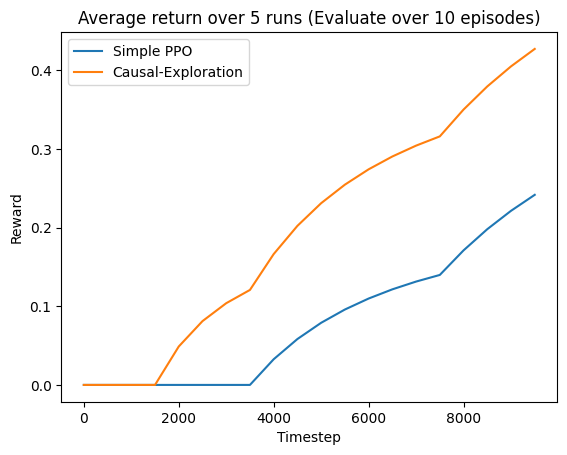

In [6]:
# Plot simple_ppo_reward
print(df_simple_PPO.index)
plt.plot(df_simple_PPO.iloc[:,0], df_simple_PPO['mean_smoothed'], label='Simple PPO')

# Plot count_base_reward
plt.plot(df_causal_reward.iloc[:,0], df_causal_reward['mean_smoothed'], label='Causal-Exploration')

# Add labels and title
plt.xlabel('Timestep')
plt.ylabel('Reward')
plt.title('Average return over 5 runs (Evaluate over 20 episodes)')

# Add legend
plt.legend()

# Display the plot
plt.show()

- While the testing environment may seem straightforward, it still provides a platform to demonstrate the benefits of the causal intrinsic reward.

- Observations reveal that the RL agent begins to exhibit improvement approximately after 2,000 training steps. Notably, this aligns with the initial training phase for the causality reward. 📈